In [ ]:
%matplotlib inline


# Compressive Sensing

This example demonstrates following features
- Adquisition step: Compressive measurements of a sparse signal 
- Recovering step: Recovering the original signal using the IHT (Iterative Hard Thresholding) algorithm.


Let's import necessary libraries 
*   [jax](https://github.com/google/jax): library for high-performance machine learning and numerical computations.
*   [cr-sparse](https://github.com/carnotresearch/cr-sparse): library for sparse signal represesentation with JAX.
* [cr-nimble](https://github.com/carnotresearch/cr-nimble): library for iterative algorithms for numerical linear algebra with JAX.

In [ ]:
import jax.numpy as jnp  # Accelerated numpy library.
from jax.numpy.linalg import norm

import matplotlib as mpl
import matplotlib.pyplot as plt

import cr.nimble as cnb
import cr.sparse as crs
import cr.sparse.dict as crdict
import cr.sparse.data as crdata
import cr.sparse.cs.cs1bit as cs1bit

import time

# Setup



In [ ]:
# Number of measurements
M = 60
# Ambient dimension
N = 500
# Sparsity level
K = 10

# Sensing Matrix

In [ ]:
from jax import random
import math
from cr.nimble import normalize_l2_cw

shape = (M, N)
normalize_atoms = True
key = cnb.KEYS[0]  # Key for pseudo-random number generation
Phi = random.normal(key, shape)
if normalize_atoms:
    Phi = normalize_l2_cw(Phi)  # Normalize directly each column of per l_2-norm
else:
    sigma = math.sqrt(M)
    Phi = Phi / sigma  # Normalize indirectly each column for Gaussian distributions

# Frame bound (You can ignore this)
s0 = crdict.upper_frame_bound(Phi)  # Computes the upper frame bound for a dictionary. Upper frame bound: https://en.wikipedia.org/wiki/Frame_(linear_algebra)
print(s0)

# Plot sensing matrix
fig=plt.figure(figsize=(8,6), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(Phi, extent=[0, 2, 0, 1])
plt.gray()
plt.colorbar()
plt.title(r'$\Phi$');

# K-sparse signal generation
_Function help_
- [sparse_normal_representations()](https://cr-sparse.readthedocs.io/en/latest/source/_autosummary/cr.sparse.data.sparse_normal_representations.html?highlight=sparse_normal_representations): Generates a set of sparse model vectors with normally distributed non-zero entries.



In [ ]:
# Generation of a random sparse vector.
x, omega = crdata.sparse_normal_representations(cnb.KEYS[1], N, K)
# normalize signal
x = x / norm(x)
# the support indices
print(omega)

# Plot sparse signal
fig=plt.figure(figsize=(8,6), dpi= 100, facecolor='w', edgecolor='k')
plt.stem(x, markerfmt='.', use_line_collection=True);

# Measurement process or acquisition step
Compressive measurements

In [ ]:
start = time.time()
y = Phi @ x  # Matrix multiplication
end = time.time()
print(f'Elapse time:{end - start}')

# Plot compressive vector
fig=plt.figure(figsize=(8,6), dpi= 100, facecolor='w', edgecolor='k')
plt.stem(y, markerfmt='.');
#print(y)

# Signal Reconstruction/Recovering using IHT

### HTP (Hard Thresholding Pursuit implementation)
- See [Greedy Sparse Recovery](https://carnotresearch.github.io/cr-sparse/source/pursuit.html)

In [ ]:
from cr.sparse.pursuit import htp
sol = htp.matrix_solve_jit(Phi, y, K, normalized=True, step_size=None, max_iters=None, res_norm_rtol=0.0001)
x_rec = crs.build_signal_from_indices_and_values(N, sol.I, sol.x_I)

[164 199 238 265 298 317 349 396 459 493]


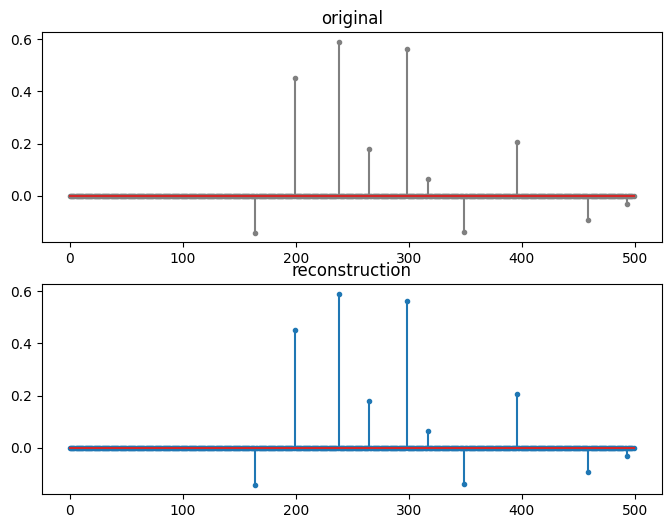

In [36]:
fig=plt.figure(figsize=(8,6), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(211)
plt.title('original')
plt.stem(x, markerfmt='.', linefmt='gray');
plt.subplot(212)
plt.stem(x_rec, markerfmt='.');
plt.title('reconstruction')

# recovered support
I = jnp.sort(sol.I)
print(I)

In [37]:
print(f'Support correctly recovered?: {jnp.array_equal(omega, I)}')
# normalize recovered signal
x_rec = x_rec / norm(x_rec)
# the norm of error
print(f'Error: {norm(x - x_rec)}')

Support correctly recovered?: True
Error: 7.076482688717078e-07
